In [1]:
import pandas as pd

import cancer_data
import many

import pyranges

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
ccle_exonusage = cancer_data.load("ccle_exonusage")
ccle_proteomics = cancer_data.load("ccle_proteomics")
ccle_genex = cancer_data.load("ccle_gene_tpm")
avana = cancer_data.load("avana")
drive = cancer_data.load("drive")

merged_ccle_info = pd.read_csv("../data/supplementary/S1_merged-ccle-info.txt",sep="\t",index_col=0)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
msi_cell_lines = set(merged_ccle_info.index[merged_ccle_info["MSI"]==True])
non_msi_cell_lines = set(merged_ccle_info.index[merged_ccle_info["MSI"]==False])

ccle_exonusage_msi = ccle_exonusage[ccle_exonusage.index.isin(msi_cell_lines)]
ccle_exonusage_non_msi = ccle_exonusage[ccle_exonusage.index.isin(non_msi_cell_lines)]

# Compute differences

In [3]:
msi_prot_diffs = many.stats.mat_mwu_naive(
    ccle_proteomics,
    merged_ccle_info["MSI"],
    effect="rank_biserial",
    melt=True,
    pbar=True,
)
msi_prot_diffs = msi_prot_diffs.reset_index()
msi_prot_diffs = msi_prot_diffs.rename({"a_col": "protein"}, axis=1).drop(
    "b_col", axis=1
)
msi_prot_diffs.to_csv("../data/supplementary/S5-a__msi-prot-diffs.txt", sep="\t")

msi_exon_diffs = many.stats.mat_mwu_naive(
    ccle_exonusage,
    merged_ccle_info["MSI"],
    effect="rank_biserial",
    melt=True,
    pbar=True,
)
msi_exon_diffs = msi_exon_diffs.reset_index()
msi_exon_diffs = msi_exon_diffs.rename({"a_col": "exon"}, axis=1).drop("b_col", axis=1)
msi_exon_diffs.to_csv("../data/intermediate/S5-b_msi-exon-diffs.txt", sep="\t")

  0%|          | 0/12755 [00:00<?, ?it/s]

  0%|          | 0/310754 [00:00<?, ?it/s]

# CCLE BAMs

In [4]:
ccle_samples = pd.read_csv("../data/raw/fullccle_samples.csv")
wgs_samples = ccle_samples[ccle_samples["datatype"] == "wgs"]
wgs_samples = wgs_samples.sort_values(by=["arxspan_id", "version", "size"])
wgs_samples = wgs_samples.drop_duplicates(subset=["arxspan_id"], keep="first")

In [5]:
msi_exons = msi_exon_diffs.copy()[msi_exon_diffs["qval"] >= 4]

msi_exons["gene"] = msi_exons["exon"].map(lambda x: x.split("_")[-1])
msi_exons["exon_chrom"] = msi_exons["exon"].map(lambda x: x.split("_")[-4][3:])
msi_exons["exon_start"] = msi_exons["exon"].map(lambda x: x.split("_")[-3])
msi_exons["exon_end"] = msi_exons["exon"].map(lambda x: x.split("_")[-2])

msi_exons["exon"] = (
    msi_exons["exon_chrom"]
    + "_"
    + msi_exons["exon_start"]
    + "_"
    + msi_exons["exon_end"]
)

msi_exons["exon_start"] = msi_exons["exon_start"].astype(int)
msi_exons["exon_end"] = msi_exons["exon_end"].astype(int)

msi_exons = msi_exons.drop_duplicates(subset=["exon"])

In [14]:
def get_exon_bounds(row, padding=1000):

    if row["exon_start"] <= row["exon_end"]:
        row["bound_start"] = row["exon_start"] - padding
        row["bound_end"] = row["exon_end"] + padding

    elif row["exon_start"] >= row["exon_end"]:
        row["bound_start"] = row["exon_end"] - padding
        row["bound_end"] = row["exon_start"] + padding

    return row


msi_exons = msi_exons.apply(get_exon_bounds, axis=1)

In [15]:
msi_exons[["exon_chrom", "bound_start", "bound_end"]].to_csv(
    "../scripts/MSI_exon_bounds.bed", sep="\t", header=False, index=False
)
msi_exons[["exon_chrom", "bound_start", "bound_end"]].to_csv(
    "../data/raw/MSI_exon_bounds.bed", sep="\t", header=False, index=False
)

In [16]:
with open("../scripts/wgs_paths.txt", "w") as f:
    for bam_path in list(wgs_samples["internal_bam_filepath"]):
        f.write(bam_path + "\n")

with open("../scripts/wgs_ids.txt", "w") as f:
    for bam_path in list(wgs_samples["arxspan_id"]):
        f.write(bam_path + "\n")

In [17]:
with open("../scripts/7_fetch-msi-slices.sh", "w") as f:
    for bam_path, ach_id in zip(
        list(wgs_samples["internal_bam_filepath"]), list(wgs_samples["arxspan_id"])
    ):

        f.write(
            "GCS_OAUTH_TOKEN=$(gcloud auth application-default print-access-token) samtools view -b -h -M -L ../data/raw/MSI_exon_bounds.bed {} > ../data/raw/WGS_slices/{}.bam\n".format(
                bam_path, ach_id
            )
        )

# Read mutations

In [4]:
msi_exon_calls = pd.read_csv(
    "../data/intermediate/msi_exon_calls/msi_exon_calls_filtered.txt",
    sep="\t",
    names=["chrom", "pos", "sample", "ref", "alt", "genotype"],
)

msi_exon_calls["snp"] = (
    msi_exon_calls["chrom"].astype(str)
    + "_"
    + msi_exon_calls["pos"].astype(str)
    + "_"
    + msi_exon_calls["ref"].astype(str)
    + ">"
    + msi_exon_calls["alt"].astype(str)
)

wgs_sample_ids = pd.read_csv(
    "../scripts/wgs_ids_samples.txt", sep="\t", names=["ach_id", "sample_name", "cn_bi"]
)
wgs_sample_map = dict(zip(wgs_sample_ids["sample_name"], wgs_sample_ids["ach_id"]))
wgs_sample_map["Detroit 562"] = "ACH-000207"

msi_exon_calls["ach_id"] = msi_exon_calls["sample"].apply(lambda x: wgs_sample_map[x])

msi_exon_calls["mut_site"] = (
    msi_exon_calls["chrom"] + "_" + msi_exon_calls["pos"].astype(str)
)
msi_exon_calls["value"] = 1
msi_exon_mut_mat = pd.pivot_table(
    msi_exon_calls, values="value", index=["ach_id"], columns="snp", fill_value=0
)

In [5]:
msi_exon_diffs = pd.read_csv(
    "../data/intermediate/S5-b_msi-exon-diffs.txt", sep="\t", index_col=0
)
msi_exon_diffs["exon"] = msi_exon_diffs["exon"].apply(
    lambda x: x.replace("_1.13e+08_", "_113000000_")
)

In [6]:
msi_exon_calls_unique = msi_exon_calls[["chrom", "pos", "snp"]].rename(
    {"chrom": "Chromosome", "pos": "Start", "snp": "SNP"}, axis=1
)
msi_exon_calls_unique = msi_exon_calls_unique.drop_duplicates(subset=["SNP"])

msi_exon_calls_unique["End"] = msi_exon_calls_unique["Start"]+1

msi_exon_calls_unique = pyranges.PyRanges(msi_exon_calls_unique)

In [7]:
msi_exon_diffs[
    ["gene", "strand", "chrom", "Start", "End", "ens_gene"]
] = msi_exon_diffs["exon"].str.rsplit("_", expand=True, n=5)

msi_exon_diffs["Start"] = msi_exon_diffs["Start"].astype(int)
msi_exon_diffs["End"] = msi_exon_diffs["End"].astype(int)

msi_exon_diffs[["Start","End"]] = np.sort(msi_exon_diffs[["Start","End"]], axis=1)

msi_exon_diffs["Chromosome"] = msi_exon_diffs["chrom"].str.split("chr").str[-1]

padding = 1000
msi_exon_diffs["Start"] = msi_exon_diffs["Start"] - padding
msi_exon_diffs["End"] = msi_exon_diffs["End"] + padding

In [8]:
msi_exon_bounds = pyranges.PyRanges(
    msi_exon_diffs[["Chromosome", "Start", "End", "exon"]]
)

In [9]:
exon_matched = msi_exon_bounds.join(
    msi_exon_calls_unique, strandedness=False, suffix="_SNP"
)
snps_by_exon = exon_matched.df.groupby("exon")["SNP"].apply(list).to_dict()

In [10]:
msi_exon_diffs["snps"] = msi_exon_diffs["exon"].apply(lambda x: snps_by_exon.get(x,[]))

In [11]:
exon_matched_snps = msi_exon_diffs[msi_exon_diffs["snps"].apply(len) > 0]

exon_matched_snps = exon_matched_snps.explode("snps")


def get_associations(row):

    exon = row["exon"]
    snp = row["snps"]

    snp_values = msi_exon_mut_mat[snp]

    if snp_values.astype(int).sum() < 5:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

    exon_values = ccle_exonusage[exon]

    corr_result = many.stats.mat_mwu_naive(
        ccle_exonusage[exon],
        msi_exon_mut_mat[snp],
        melt=True,
        effect="rank_biserial",
        use_continuity=True,
    )

    corr_result = corr_result.iloc[0].to_dict()

    return (
        corr_result["rank_biserial"],
        corr_result["pval"],
        corr_result["qval"],
        corr_result["pos_n"],
        corr_result["neg_n"],
    )

In [12]:
(
    exon_matched_snps["exon_snp_rank_biserial"],
    exon_matched_snps["exon_snp_pval"],
    exon_matched_snps["exon_snp_qval"],
    exon_matched_snps["exon_snp_pos_n"],
    exon_matched_snps["exon_snp_neg_n"],
) = zip(*exon_matched_snps.progress_apply(get_associations,axis=1))

  0%|          | 0/11764 [00:00<?, ?it/s]

In [13]:
filtered_exon_snps = exon_matched_snps[exon_matched_snps["exon_snp_qval"]>2]

In [14]:
correlated_exons = ccle_exonusage[filtered_exon_snps["exon"]]
correlated_snps = msi_exon_mut_mat[filtered_exon_snps["snps"]]

msi_cell_lines = set(merged_ccle_info.index[merged_ccle_info["MSI"]==True])

correlated_exons = correlated_exons[correlated_exons.index.isin(msi_cell_lines)]
correlated_snps = correlated_snps[correlated_snps.index.isin(msi_cell_lines)]

correlated_exons, correlated_snps = correlated_exons.align(correlated_snps,join="inner",axis=0)


In [15]:
def make_exon_msi_plots(exon, gene, protein, mutation):

    select_exon = ccle_exonusage[exon]
    select_exon_msi = ccle_exonusage_msi[exon]
    select_exon_non_msi = ccle_exonusage_non_msi[exon]

    select_protein = ccle_proteomics[protein]

    select_gene = ccle_genex[gene]
    select_mutation = msi_exon_mut_mat[mutation].astype(bool).astype(str)

    plt.figure(figsize=(12, 4))

    ax = plt.subplot(141)
    sns.scatterplot(select_exon, select_protein, hue=select_mutation)
    ax.set_title("Exonusage vs protein")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax = plt.subplot(142)
    sns.scatterplot(select_exon, select_gene, hue=select_mutation)
    ax.set_title("Exonusage vs mRNA")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax = plt.subplot(143)
    sns.scatterplot(select_exon_msi, select_gene, hue=select_mutation)
    ax.set_title("Exonusage vs mRNA (MSI only)")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax = plt.subplot(144)
    sns.scatterplot(select_exon_non_msi, select_gene, hue=select_mutation)
    ax.set_title("Exonusage vs mRNA (non-MSI only)")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)


In [67]:
cosmic_genes = pd.read_csv("../data/raw/cancer_gene_census.csv")
ensembl_t2g = pd.read_csv("../data/intermediate/sleuth_diff/ensembl_t2g.csv")

ensembl_t2g = ensembl_t2g.dropna(subset=["entrez_gene"])
ensembl_t2g["entrez_gene"] = ensembl_t2g["entrez_gene"].astype(int)
entrez_to_ensembl = dict(zip(ensembl_t2g["entrez_gene"], ensembl_t2g["ens_gene"]))
ensembl_to_entrez = dict(zip(ensembl_t2g["ens_gene"], ensembl_t2g["entrez_gene"]))


cosmic_genes = cosmic_genes.dropna(subset=["Entrez GeneId"])
cosmic_genes["ensembl_id"] = cosmic_genes["Entrez GeneId"].apply(entrez_to_ensembl.get)

ensembl_to_role = dict(zip(cosmic_genes["ensembl_id"],cosmic_genes["Role in Cancer"]))

filtered_exon_snps["cosmic_role"] = filtered_exon_snps["ens_gene"].apply(
    lambda x: ensembl_to_role.get(x.split(".")[0])
)

<ipython-input-67-653fc3136ce6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exon_snps["cosmic_role"] = filtered_exon_snps["ens_gene"].apply(


In [60]:
filtered_exon_snps.to_csv("~/Desktop/filtered_exon_snps.txt",sep="\t")

In [92]:
entrez_to_avana = dict(zip([x.split("_")[-1] for x in avana.columns], avana.columns))
entrez_to_drive = dict(zip([x.split("_")[-1] for x in drive.columns], drive.columns))


filtered_exon_snps["entrez_gene"] = (
    filtered_exon_snps["ens_gene"]
    .apply(lambda x: ensembl_to_entrez.get(x.split(".")[0]))
    .astype("Int64").astype(str)
)
filtered_exon_snps["avana_gene"] = filtered_exon_snps["entrez_gene"].apply(
    entrez_to_avana.get
)
filtered_exon_snps["drive_gene"] = filtered_exon_snps["entrez_gene"].apply(
    entrez_to_drive.get
)

<ipython-input-92-0a64e302b1be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exon_snps["entrez_gene"] = (
<ipython-input-92-0a64e302b1be>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exon_snps["avana_gene"] = filtered_exon_snps["entrez_gene"].apply(
<ipython-input-92-0a64e302b1be>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [93]:
def get_exon_dependency_corr(row):

    avana_gene = row["drive_gene"]

    if avana_gene not in avana.columns:
        return (np.nan, np.nan, np.nan, np.nan)

    corr_result = many.stats.mat_corr_naive(
        ccle_exonusage[row["exon"]],
        avana[avana_gene],
        melt=True,
        method="pearson",
    )

    corr_result = corr_result.iloc[0].to_dict()

    return (
        corr_result["pearson"],
        corr_result["pval"],
        corr_result["qval"],
        corr_result["n"],
    )

In [94]:
(
    filtered_exon_snps["exon_dependency_pearson"],
    filtered_exon_snps["exon_dependency_pval"],
    filtered_exon_snps["exon_dependency_qval"],
    filtered_exon_snps["exon_dependency_n"],
) = zip(*filtered_exon_snps.progress_apply(get_exon_dependency_corr, axis=1))

  0%|          | 0/973 [00:00<?, ?it/s]

<ipython-input-94-1ecbf0d3bfb4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exon_snps["exon_dependency_pearson"],
<ipython-input-94-1ecbf0d3bfb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exon_snps["exon_dependency_pval"],
<ipython-input-94-1ecbf0d3bfb4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [95]:
filtered_exon_snps.sort_values(by="exon_dependency_qval").dropna(subset=["exon_dependency_qval"])

,exon,rank_biserial,pval,qval,pos_n,neg_n,gene,strand,chrom,Start,...,exon_snp_pos_n,exon_snp_neg_n,cosmic_role,entrez_gene,avana_gene,exon_dependency_pearson,exon_dependency_pval,exon_dependency_qval,exon_dependency_n,drive_gene
8410,MSH2_3p_chr2_47635540_47635694_ENSG00000095002.8,-0.202237,3.452069,1.884500,73.0,866.0,MSH2,3p,chr2,47634540,...,22.0,306.0,None,4436,MSH2_4436,0.000013,0.000107,0.000107,582.0,MSH2_4436
153,ANKRD26_5p_chr10_27333119_27333086_ENSG0000010...,-0.636016,18.104846,14.799950,69.0,818.0,ANKRD26,5p,chr10,27332086,...,152.0,163.0,None,22852,ANKRD26_22852,0.000665,0.005447,0.005447,555.0,ANKRD26_22852
153,ANKRD26_5p_chr10_27333119_27333086_ENSG0000010...,-0.636016,18.104846,14.799950,69.0,818.0,ANKRD26,5p,chr10,27332086,...,36.0,279.0,None,22852,ANKRD26_22852,0.000665,0.005447,0.005447,555.0,ANKRD26_22852
208,PRKCE_5p_chr2_46072534_46072897_ENSG00000171132.9,-0.655983,15.567861,12.395591,56.0,702.0,PRKCE,5p,chr2,46071534,...,14.0,252.0,None,5581,PRKCE_5581,0.002490,0.018808,0.018808,458.0,PRKCE_5581
208,PRKCE_5p_chr2_46072534_46072897_ENSG00000171132.9,-0.655983,15.567861,12.395591,56.0,702.0,PRKCE,5p,chr2,46071534,...,15.0,251.0,None,5581,PRKCE_5581,0.002490,0.018808,0.018808,458.0,PRKCE_5581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,TTC37_5p_chr5_94842715_94842638_ENSG00000198677.6,-0.908024,37.797874,32.907517,74.0,867.0,TTC37,5p,chr5,94841638,...,31.0,297.0,None,9652,TTC37_9652,0.118498,2.380039,2.380039,583.0,TTC37_9652
273,POT1_5p_chr7_124488713_124488594_ENSG000001285...,0.527500,13.526544,10.471878,75.0,864.0,POT1,5p,chr7,124487594,...,19.0,307.0,TSG,25913,POT1_25913,-0.122360,2.485697,2.485697,576.0,POT1_25913
273,POT1_5p_chr7_124488713_124488594_ENSG000001285...,0.527500,13.526544,10.471878,75.0,864.0,POT1,5p,chr7,124487594,...,17.0,309.0,TSG,25913,POT1_25913,-0.122360,2.485697,2.485697,576.0,POT1_25913
232,EPS15_5p_chr1_51924405_51924068_ENSG0000008583...,-0.553384,14.693307,11.568246,74.0,867.0,EPS15,5p,chr1,51923068,...,20.0,308.0,"TSG, fusion",2060,EPS15_2060,-0.122274,2.507915,2.507915,583.0,EPS15_2060


In [ ]:
ccle_exonusage["NUMA1_3p_chr11_71760585_71760465_ENSG00000137497.13"]
ccle_proteomics["NUMA1_H0YFY6"]

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

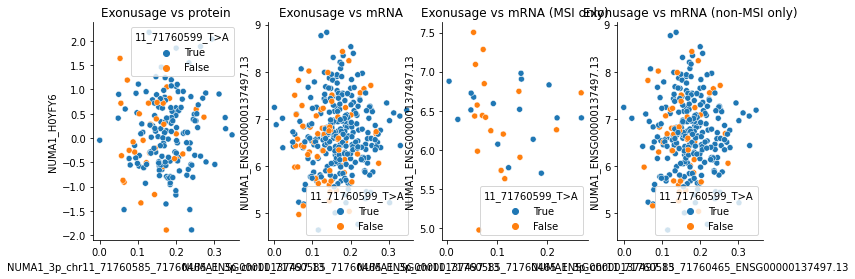

In [58]:
make_exon_msi_plots(
    "NUMA1_3p_chr11_71760585_71760465_ENSG00000137497.13",
    "NUMA1_ENSG00000137497.13",
    "NUMA1_H0YFY6",
    "11_71760599_T>A",
)

plt.savefig("../plots/NUMA1_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

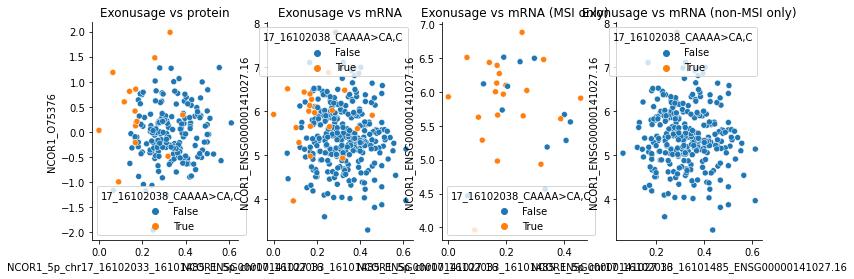

In [57]:
make_exon_msi_plots(
    "NCOR1_5p_chr17_16102033_16101485_ENSG00000141027.16",
    "NCOR1_ENSG00000141027.16",
    "NCOR1_O75376",
    "17_16102038_CAAAA>CA,C",
)

plt.savefig("../plots/NCOR1_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

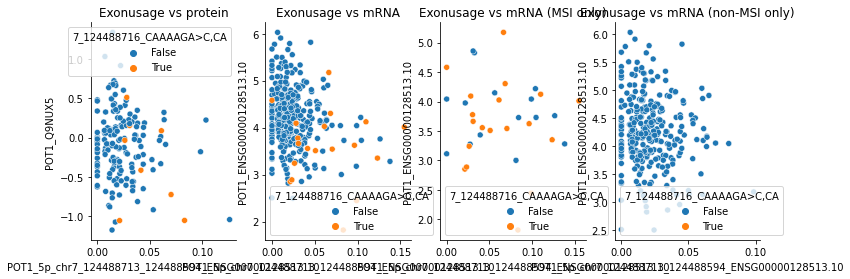

In [55]:
make_exon_msi_plots(
    "POT1_5p_chr7_124488713_124488594_ENSG00000128513.10",
    "POT1_ENSG00000128513.10",
    "POT1_Q9NUX5",
    "7_124488716_CAAAAGA>C,CA",
)

plt.savefig("../plots/POT1_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

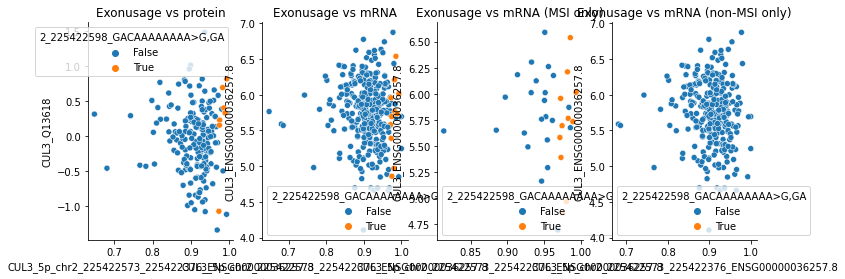

In [52]:
make_exon_msi_plots(
    "CUL3_5p_chr2_225422573_225422376_ENSG00000036257.8",
    "CUL3_ENSG00000036257.8",
    "CUL3_Q13618",
    "2_225422598_GACAAAAAAAA>G,GA",
)

plt.savefig("../plots/CUL3_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

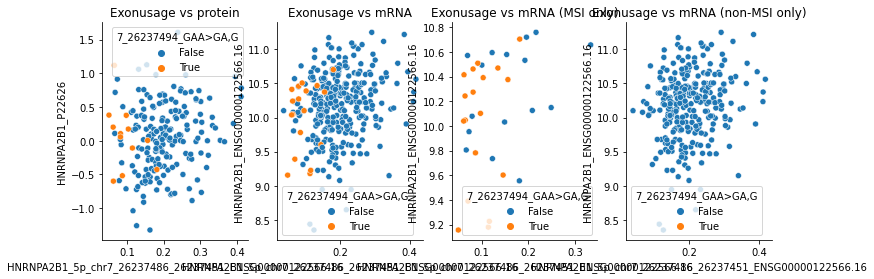

In [51]:
make_exon_msi_plots(
    "HNRNPA2B1_5p_chr7_26237486_26237451_ENSG00000122566.16",
    "HNRNPA2B1_ENSG00000122566.16",
    "HNRNPA2B1_P22626",
    "7_26237494_GAA>GA,G",
)

plt.savefig("../plots/HNRNPA2B1_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

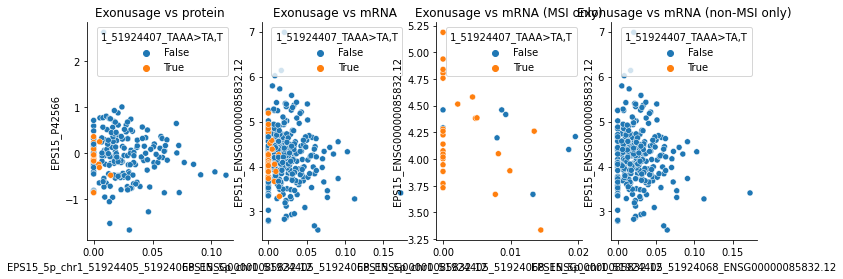

In [50]:
make_exon_msi_plots(
    "EPS15_5p_chr1_51924405_51924068_ENSG00000085832.12",
    "EPS15_ENSG00000085832.12",
    "EPS15_P42566",
    "1_51924407_TAAA>TA,T",
)

plt.savefig("../plots/EPS15_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

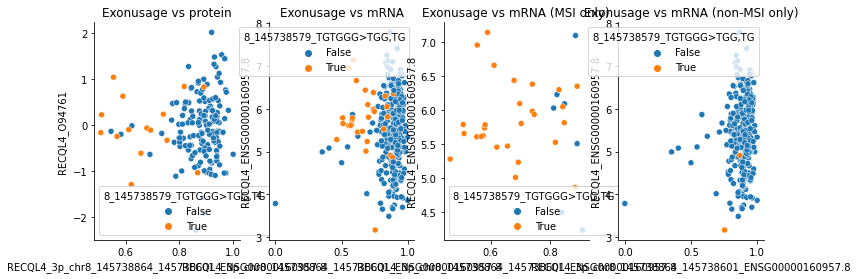

In [49]:
make_exon_msi_plots(
    "RECQL4_3p_chr8_145738864_145738601_ENSG00000160957.8",
    "RECQL4_ENSG00000160957.8",
    "RECQL4_O94761",
    "8_145738579_TGTGGG>TGG,TG",
)

plt.savefig("../plots/RECQL4_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

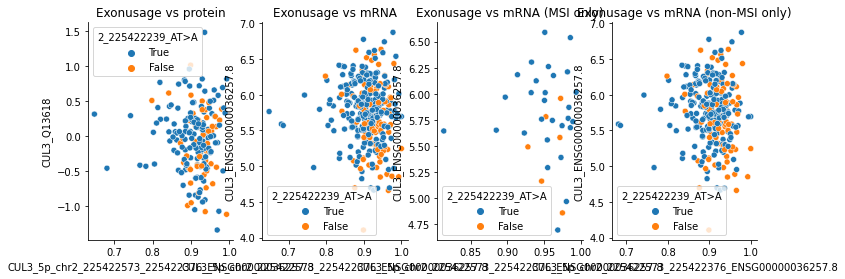

In [44]:
make_exon_msi_plots(
    "CUL3_5p_chr2_225422573_225422376_ENSG00000036257.8",
    "CUL3_ENSG00000036257.8",
    "CUL3_Q13618",
    "2_225422239_AT>A",
)

plt.savefig("../plots/CUL3_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

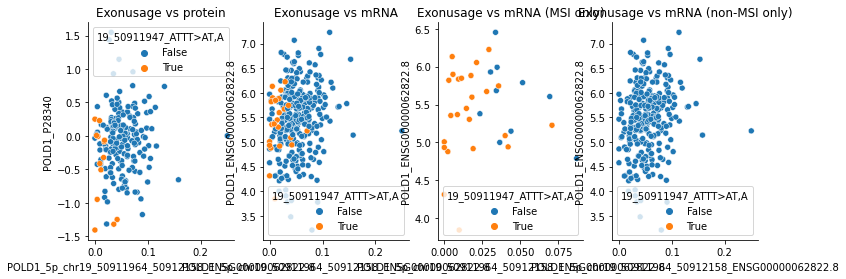

In [47]:
make_exon_msi_plots(
    "POLD1_5p_chr19_50911964_50912158_ENSG00000062822.8",
    "POLD1_ENSG00000062822.8",
    "POLD1_P28340",
    "19_50911947_ATTT>AT,A",
)

plt.savefig("../plots/POLD1_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

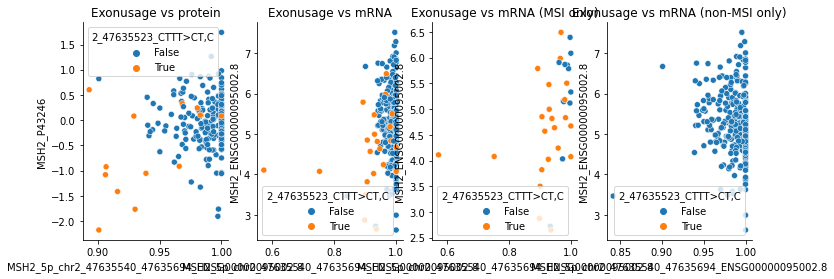

In [106]:
make_exon_msi_plots(
    "MSH2_5p_chr2_47635540_47635694_ENSG00000095002.8",
    "MSH2_ENSG00000095002.8",
    "MSH2_P43246",
    "2_47635523_CTTT>CT,C",
)

plt.savefig("../plots/MSH2_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

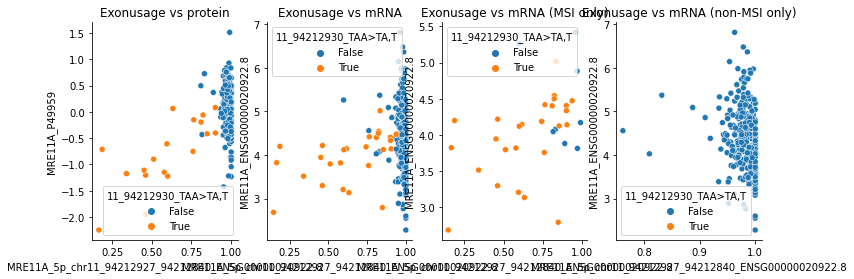

In [107]:
make_exon_msi_plots(
    "MRE11A_5p_chr11_94212927_94212840_ENSG00000020922.8",
    "MRE11A_ENSG00000020922.8",
    "MRE11A_P49959",
    "11_94212930_TAA>TA,T",
)

plt.savefig("../plots/MRE11A_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

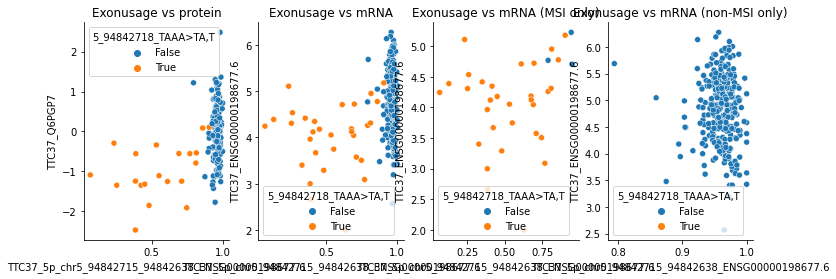

In [108]:
make_exon_msi_plots(
    "TTC37_5p_chr5_94842715_94842638_ENSG00000198677.6",
    "TTC37_ENSG00000198677.6",
    "TTC37_Q6PGP7",
    "5_94842718_TAAA>TA,T",
)

plt.savefig("../plots/TTC37_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

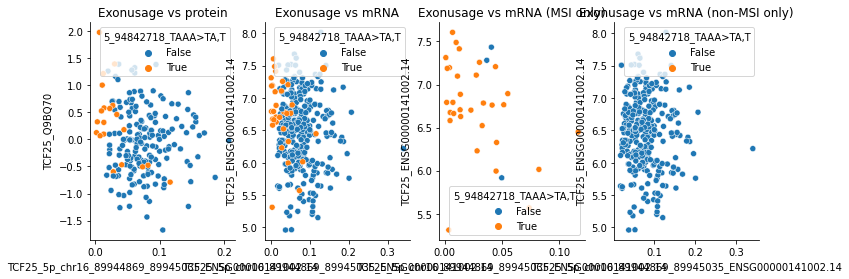

In [109]:
make_exon_msi_plots(
    "TCF25_5p_chr16_89944869_89945035_ENSG00000141002.14",
    "TCF25_ENSG00000141002.14",
    "TCF25_Q9BQ70",
    "5_94842718_TAAA>TA,T",
)

plt.savefig("../plots/TCF25_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

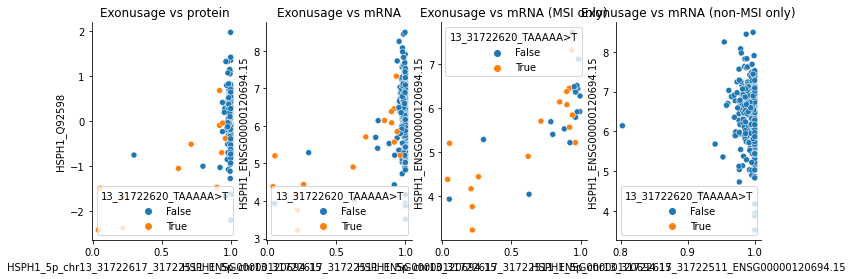

In [110]:
make_exon_msi_plots(
    "HSPH1_5p_chr13_31722617_31722511_ENSG00000120694.15",
    "HSPH1_ENSG00000120694.15",
    "HSPH1_Q92598",
    "13_31722620_TAAAAA>T",
)

plt.savefig("../plots/HSPH1_polya_truncations.pdf", bbox_inches="tight")